In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import emcee
import corner
import pickle
from multiprocessing import Pool

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )
    
# set random number seed to ensure reproducibility
seed = 3
rstate = np.random.RandomState(seed)

## Implementing MCMC using GP Emulator Model

In [2]:
path = os.path.dirname(os.getcwd())
os.chdir(path)
from Emulator.Classes.AllData import AllData
from Emulator.Classes.LightCurve import utkarshGrid, LightCurve
from Emulator.Classes.GP import GP
from Emulator.Classes.GP2D import GP2D
from Emulator.Classes.GP5D import GP5D
from Emulator.Classes.Inference import Inference
os.chdir(os.getcwd() + "/Emulator")
os.getcwd()

'/Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator'

In [3]:
gp = GP5D("Classes/reference.csv")
gp.delete_folder_files("data/pcaComponents")
gp.delete_folder_files("data/pcaComponentsTrained")
gp.delete_folder_files("data/pcaComponentsTrainedError")
gp.delete_folder_files("data/pcaTrained")
gp.delete_folder_files("data/pcaTrainedUpper")
gp.delete_folder_files("data/pcaTrainedLower")

In [4]:
inference = Inference()
inference.truth_arr = np.array([0.01, 0.13, 60, 4])
inference.mejdyn_guess, inference.mejwind_guess, inference.phi_guess, inference.iobs_guess = list(inference.truth_arr)
inference.nwalkers = 10
inference.nburn = 1#2000
inference.niter = 2000#2000 
inference.train_fluxes()

Training Time: 81s


In [5]:
inference.main(yerr_percentage = 20)

(100, 350)


  0%|          | 0/1 [00:00<?, ?it/s]

Started Burn-In


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning:invalid value encountered in double_scalars
  0%|          | 0/2000 [00:00<?, ?it/s]

Burn-In Took: 0.02mins


100%|██████████| 2000/2000 [1:22:12<00:00,  2.47s/it]


In [6]:
inference.samples = inference.sampler.get_chain()
inference.iobs_to_degrees()
inference.labs = [r'Dynamical Ejecta Mass $M_\odot$', r'Wind Ejecta Mass $M_\odot$', r'Half-Opening Angle ($\Phi$)', "Viewing Angle (deg)"]

Walkers: 10
Iterations: 2000
Emulator Calls: 5045
Total Runtime: 82.25mins


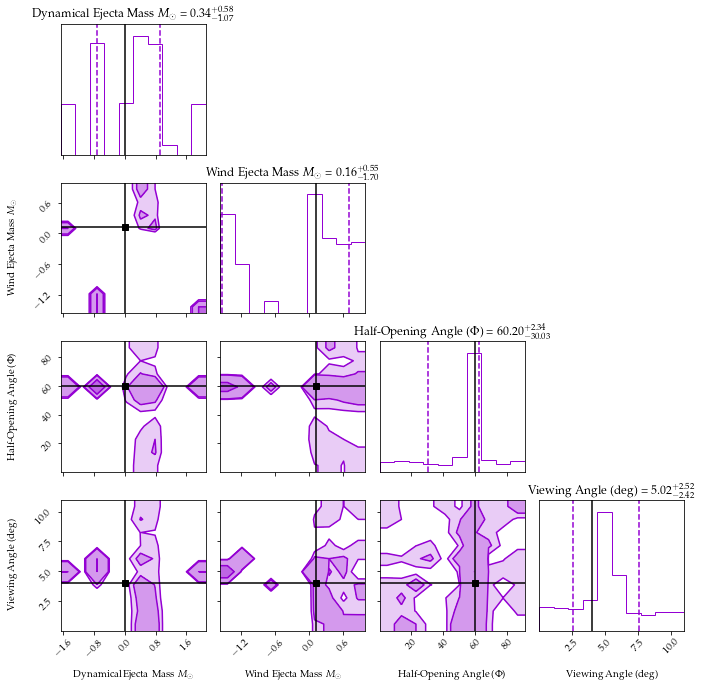

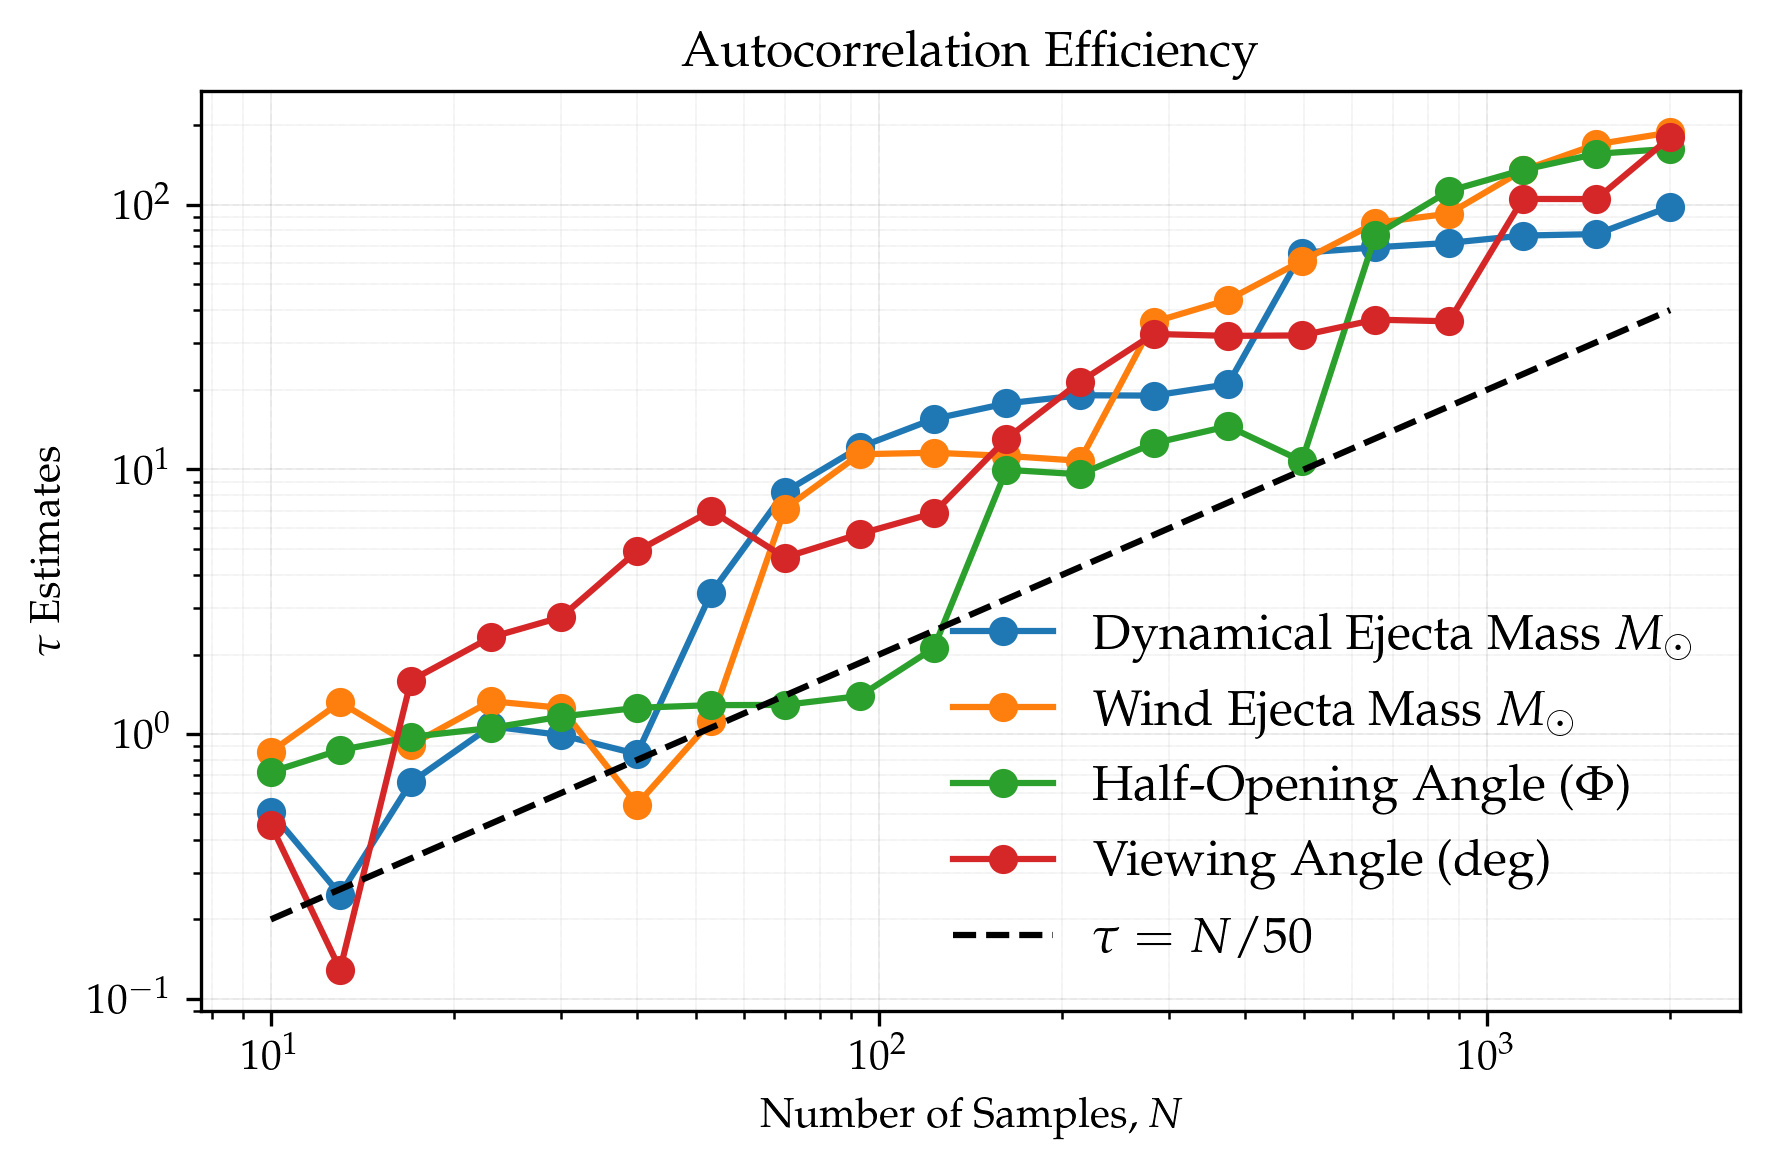

In [7]:
inference.plot_corner()
inference.plot_auto_correlation()
# inference.plot_chains()
plt.show()

Walkers: 10
Iterations: 2000
Emulator Calls: 5045
Total Runtime: 90.68mins


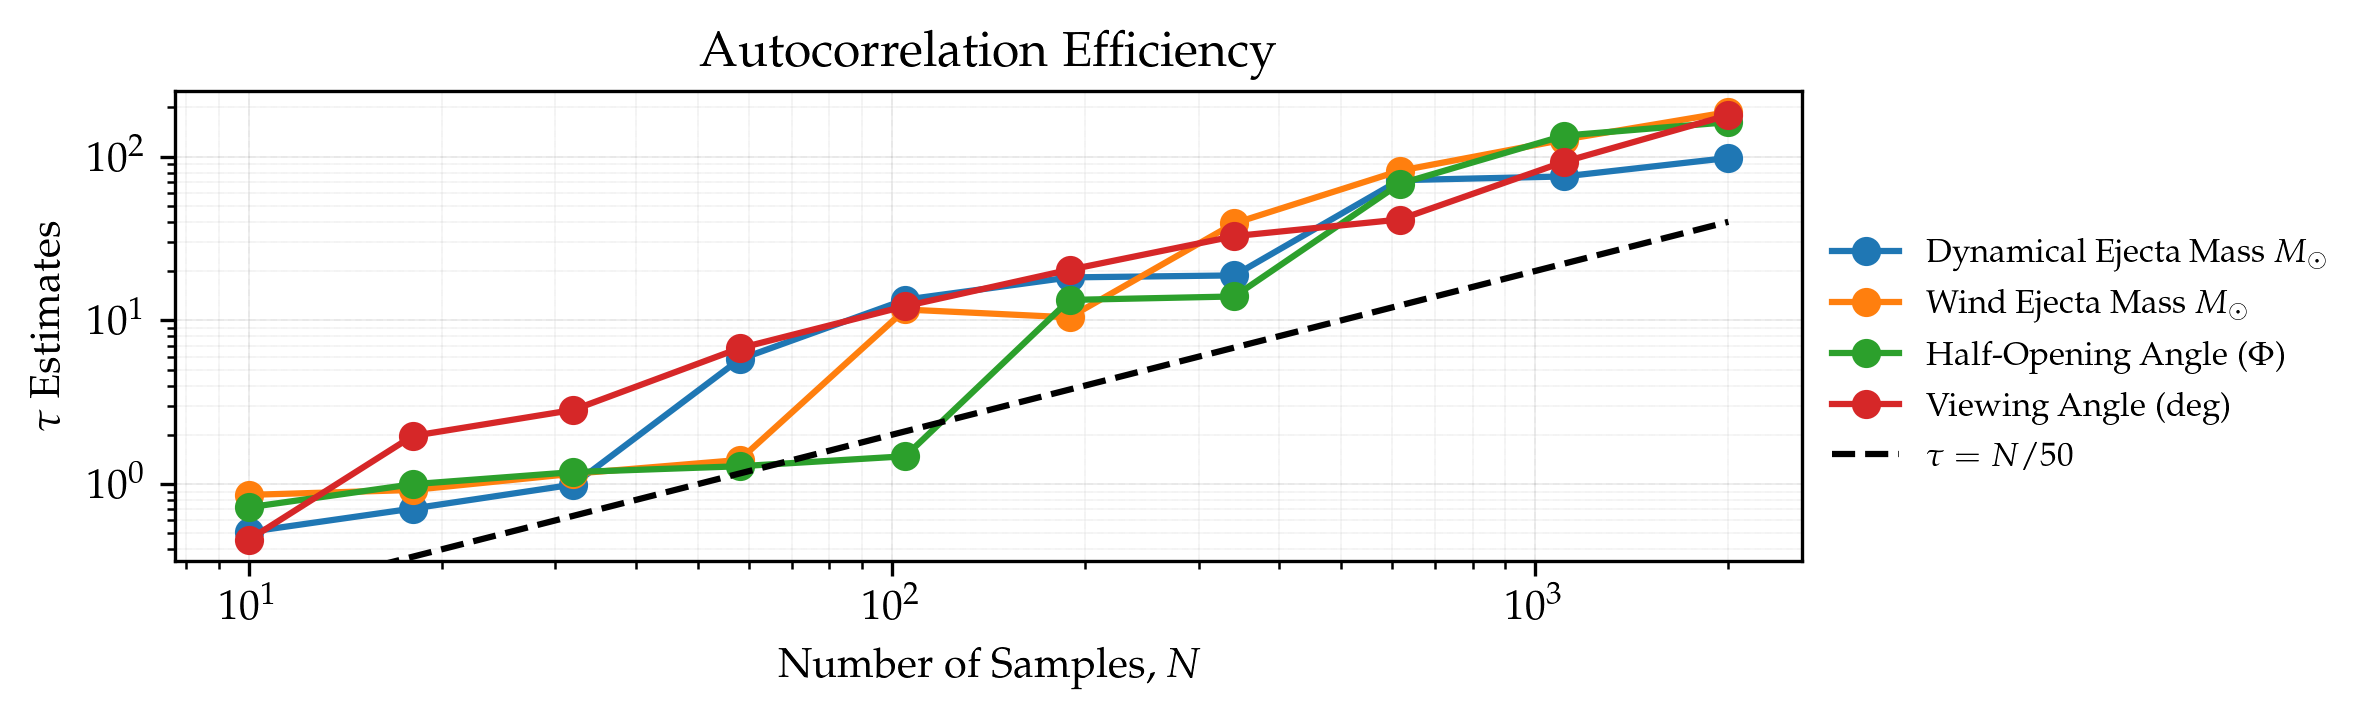

In [46]:
self = inference
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

plt.figure(dpi=300, figsize = (8,2.5))
for dimension in range(len(self.initial)):
    chain = self.sampler.get_chain()[:, :, dimension].T
    N = np.exp(np.linspace(np.log(10), np.log(chain.shape[1]), 10)).astype(int)

    # Compute the estimators for a few different chain lengths
    gw2010 = np.empty(len(N))
    new = np.empty(len(N))
    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(chain[:, :n])
    #         new[i] = autocorr_new(chain[:, :n])

    # Plot the comparisons
    plt.loglog(N, gw2010, "o-", label=f"{self.labs[dimension]}")
#     plt.loglog(N, new, "o-", label=f"New: {labs[dimension]}")

ylim = plt.gca().get_ylim()
plt.ylim(ylim)
plt.xlabel("Number of Samples, $N$")
plt.ylabel(r"$\tau$ Estimates")
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.legend(fontsize=8, ncol=1, bbox_to_anchor=(1, 0.75), loc='upper left')
plt.title(f"Autocorrelation Efficiency")
utkarshGrid()
print(f"Walkers: {self.nwalkers}\nIterations: {self.niter}"
      f"\nEmulator Calls: {self.emulator_calls}\nTotal Runtime: {round((time.time() - self.t_init) / 60, 2)}mins")
